In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import solve, cholesky

%matplotlib inline

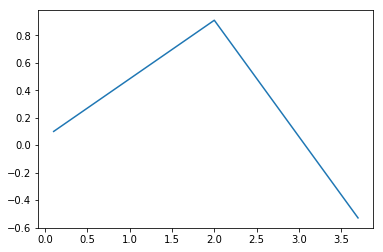

In [29]:
n = 50
X_train = np.array([0.1, 2, 3.7])
y_train = np.sin(X_train)

X_test = np.linspace(0, 5, num=n)


plt.plot(X_train, y_train)

## Random derpings from http://katbailey.github.io/post/gaussian-processes-for-dummies/

In [ ]:
# Noiseless training data
Xtrain = np.array([-4, -3, -2, -1, 1]).reshape(5,1)
ytrain = np.sin(Xtrain)

# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain, param)
K_s = kernel(Xtrain, Xtest, param)



L = np.linalg.cholesky(K)

# Compute the mean at our test points.
Lk = L \ K_s
mu = Lk.T @ (L \ ytrain)

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)

# Draw samples from the posterior at our test points.

Lsamp = np.linalg.cholesky(K_ss - Lk.T @ Lk)
f_post = mu.reshape(-1,1) + Lsamp @ np.random.normal(size=(n,3))


In [ ]:
L = np.linalg.cholesky(K)

# Compute the mean at our test points.
Lk = L \ K_s
mu = (L \ K_s)^T @ (L \ ytrain)

mu = K_s @ L.T \ (L \ ytrain)

In [ ]:
solve(L, Ks).T @ solve(L, y)

In [ ]:
Ks.T @ solve(L.T, solve(L, y))

In [ ]:
Ks.T @ np.linalg.inv(K) @ y

In the basic form we have $K_* = k(X, X_*), K_{**} = k(X_*, X_*), K = k(X, X)$, which gives us the following posterior

$$
\begin{align}
    \mu &= K_* K^{-1} y \\
    var &= K_{**} - K_* K^{-1} K_*^T.
\end{align}
$$

We can also write

$$
\begin{align}
    L &= cholesky(K) \\
    \alpha &= L^T \backslash (L \backslash y) \\
    \mu &= K_*^T \alpha \\
    v &= L \backslash K_* \\
    var &= K_{**} - v^T v,
\end{align}
$$

and we also know that

$$
(L \backslash K_*)^T (L \backslash y) = K_*^T (L^T \backslash (L \backslash y)) = K_* K^{-1} y
$$

(50, 3)

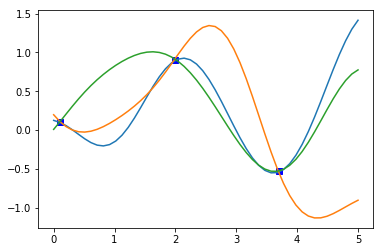

In [49]:
def plots(*plots, n_row=3, figsize=(15,4)):
    num_rows = len(plots) // n_row + 1
      
    plt.figure(figsize=figsize)
        
    for i, plot in enumerate(plots):
        plt.subplot(num_rows, n_row, i+1)
        plt.imshow(plot)
    
    plt.show()

def sqexp(x,y):
    return np.exp(-.5 * 1 * (x*x + y*y - 2*x*y))

def k(x, y=None, kernel=sqexp):
    if y is None:
        y = x
        
    return kernel(*np.meshgrid(y,x)) + 1e-12*np.eye(x.shape[0], y.shape[0])

def gp_reg(X_train, y_train, X_test, kernel):
    n = len(X_test)
    
    K = k(X_train, X_train)
    Kss = k(X_test, X_test)
    Ks = k(X_train, X_test)
    
    K_inv = np.linalg.inv(K + 1e-4 * np.eye(K.shape[0]))

    L = np.linalg.cholesky(K + 1e-4 * np.eye(K.shape[0]))

    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))   # equiv K_inv@y


    mu_post = Ks.T @ alpha
    cov_post = Kss - Ks.T @ K_inv @ Ks

    #Lk = solve(L, Ks)
    #L = np.linalg.cholesky(Kss + 1e-6*np.eye(n) - (Lk.T @ Lk))
    
    #f_post = mu_post.reshape(-1,1) + (cholesky(cov_post) @ np.random.normal(size=(n,3)))
    
    return mu_post, cov_post, cholesky(cov_post)
        
    # plt.plot(mu_post.reshape(-1,1) + np.linalg.cholesky(cov_post) @ np.random.randn(3, 5));
    # y_post = post_mu + np.linalg.cholesky(cov_post) @ np.random.randn()


mu_post, cov_post, L = gp_reg(X_train, y_train, X_test, k)

f_post = mu_post.reshape(-1, 1) + cholesky(cov_post) @ np.random.randn(n, 3)

plt.plot(X_train, y_train, 'bs')
plt.plot(X_test, f_post);
f_post.shape
#plt.plot(f_post)

# plots(Kss, Ks, Ks.T, K)

In [ ]:
a = np.array([[3,1], [1,2]])
b = np.array([9,8])

In [ ]:
L = np.linalg.cholesky(a)
# LL'x = b
# Ly = b
# L'x = y
# -> LL'x = b -> Ax = b

x = np.linalg.solve(L.T, np.linalg.solve(L, b))
x

In [ ]:
np.linalg.inv(L@L.T) @ b

In [ ]:
np.linalg.inv(a) @ b

In [ ]:
np.all(K.T == K)

In [ ]:
L = np.linalg.cholesky(K + 1e-12*np.eye(n))

In [ ]:
plt.plot(L @ np.random.randn(n, 50));